Data is provided for **Las Vegas, Nevada, United States**, and the stations the data comes from are shown on the map below.

Included is a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day is shaded.
A scatter is overlaid using 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.

(*RNN for temp predictions to come.)



In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import numpy as np
from matplotlib.ticker import MaxNLocator

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'b7d026ded3527654e3d52ec42f195e7b759550d7ee71c0aed35eb691')

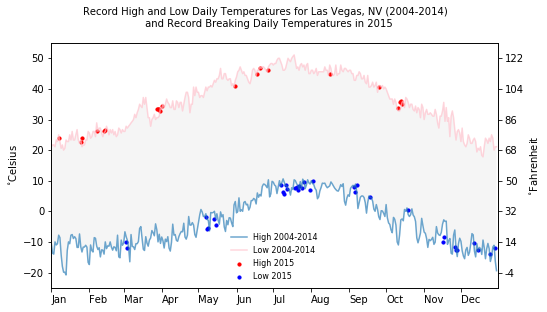

In [2]:
from matplotlib.ticker import FormatStrFormatter

df = pd.read_csv('b7d026ded3527654e3d52ec42f195e7b759550d7ee71c0aed35eb691.csv')
df = pd.DataFrame(df)

#converting dates to pandas datetime type 
df['Date'] = pd.to_datetime(df['Date'])

#define: day, month, year
df['Day'] = pd.DatetimeIndex(df['Date']).day 
df['Month'] = pd.DatetimeIndex(df['Date']).month 
df['Year'] = pd.DatetimeIndex(df['Date']).year

#dropping Feb-29
drop_Feb29 = df[(df.Date.dt.month == 2) & (df.Date.dt.day == 29)]
df.drop(drop_Feb29.index, inplace=True)

#converting to Celcius and Fahrenheit 
df['Data_Value'] = df['Data_Value']/10
#df['Data_Fahr'] = (df['Data_Value'] * (9/5)) + 32

#splitting data into 2004 and 2015 data
df_2015 = df[df.Year == 2015]
df = df[(df.Year >= 2005) & (df.Year <= 2014)]

#deleting id columns 
del df['ID']
del df_2015['ID']

#create dataframes for tmin and tmax 
df_tmin = df[df['Element'] == 'TMIN'] 
df_tmax = df[df['Element'] == 'TMAX']
df_tmin2015 = df_2015[df_2015['Element'] == 'TMIN']
df_tmax2015 = df_2015[df_2015['Element'] == 'TMAX'] 

#create series of tmax and tmin for 365 days
tmin = df_tmin.groupby([df_tmin['Month'],df_tmin['Day']])['Data_Value'].min()
tmax = df_tmax.groupby([df_tmax['Month'],df_tmax['Day']])['Data_Value'].max()
tmin_2015 = df_tmin2015.groupby([df_tmin2015['Month'],df_tmin2015['Day']])['Data_Value'].min()
tmax_2015 = df_tmax2015.groupby([df_tmax2015['Month'],df_tmax2015['Day']])['Data_Value'].max()

#convert 2015 index to dayofyear 
tmin_2015.index =tmin_2015.index.map(
    lambda x: pd.to_datetime('2015-{}-{}'.format(x[0],x[1]),format='%Y-%m-%d').dayofyear)
tmax_2015.index =tmax_2015.index.map(
    lambda x: pd.to_datetime('2015-{}-{}'.format(x[0],x[1]),format='%Y-%m-%d').dayofyear)

#set up a linear graph and fill between min and max
fig = plt.figure(figsize=(8,5))
plt.plot(tmin.values,'-',alpha = 0.65, label = 'High 2004-2014')
plt.plot(tmax.values, '-',alpha = 0.65,color='pink',label = 'Low 2004-2014')
plt.fill_between(range(len(tmin)),tmin.values,tmax.values,facecolor='gray',alpha=0.075) #alpha: transparency level 


#set x-axis ticks and set labels to months using 2015  
xticks = (pd.date_range('1/1/2015','31/12/2015',freq='M') - 1 + pd.Timedelta('1D')).strftime('%-j').astype(int)
xticks_labels = pd.to_datetime(xticks,format='%j').strftime('%b')
ax = plt.gca()
ax.set_xlim(1,365)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks_labels);
fig.autofmt_xdate(ha='left',rotation=None)


# create scatterplot for record breaking points over line graph  
label_point = True 
for i in range(len(tmax_2015)):
    if tmax_2015.values[i] > tmax.values[i]: 
        if label_point: 
            plt.scatter(tmax_2015.index[i], tmax_2015.values[i], s = 10, c = 'red', label = "High 2015")
            label_point = False 
        else: 
            plt.scatter(tmax_2015.index[i], tmax_2015.values[i], s = 10, c = 'red',label=None)

label_point = True
for i in range(len(tmin_2015)):
    if tmin_2015.values[i] < tmin.values[i]: 
        if label_point: 
            plt.scatter(tmin_2015.index[i], tmin_2015.values[i], s = 10, c = 'blue', label = "Low 2015")
            label_point = False 
        else: 
            plt.scatter(tmin_2015.index[i], tmin_2015.values[i], s = 10, c = 'blue',label=None)
            

#set legend 
plt.legend(loc=8,frameon = False, prop= {'size':8},title = None)

#set ytick values 
axis_left = [-20,-10,0,10,20,30,40,50]
axis_right = [int(1.8*x + 32) for x in axis_left]



ax1 = ax.twinx(); #set dual y-axes
ax.set_yticks(axis_left) #values for left y-axis
ax.set_ybound(lower = -25,upper = 55) #adjust y-axis values position 



#set values for right-yaxis 
ax1.set_yticks(ax.get_yticks()); 
ax1.set_ylim(ax.get_ylim());
ax1.set_yticklabels(axis_right)
#ax1.set_yticklabels(map(lambda x : '{:}'.format((x*1.8)+32),ax1.get_yticks()))

#set axes labels 
ax.set_ylabel('$^{\circ}$Celsius')
ax1.set_ylabel('$^{\circ}$Fahrenheit')

#set title
plt.suptitle('Record High and Low Daily Temperatures for Las Vegas, NV (2004-2014) \n and Record Breaking Daily Temperatures in 2015',fontsize=10)

#save graph
plt.savefig("Record_Temperatures.png",bbox_inches='tight')

#show graph
plt.show()
  
